# Moondream 1.9B
- Announcement: https://moondream.ai/blog/introducing-a-new-moondream-1-9b-and-gpu-support
- Playground: https://moondream.ai/playground
- Moondream Cloud: https://console.moondream.ai/
- Documentation: https://docs.moondream.ai/quick-start
- HuggingFace: https://huggingface.co/vikhyatk/moondream2

Code according to: https://docs.moondream.ai/quick-start

In [ ]:
!pip install pyvips-binary pyvips transformers einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 63.0 MB/s eta 0:00:00
  Created wheel for pyvips: filename=pyvips-2.2.3-py2.py3-none-any.whl size=54849 sha256=db677626c87982580aafade25aeaccc04fd8f2caa32bd91c74f84edb16b7f8f0
  Stored in directory: /root/.cache/pip/wheels/fc/2c/3a/120103ac3f113407daed5416c5386cd13172c92f68ee9f7208
Successfully built pyvips


In [ ]:
from datetime import datetime
from io import BytesIO
from IPython.display import display # For Google Colab
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import requests
from transformers import AutoModelForCausalLM, AutoTokenizer # pip install transformers


In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2", # https://huggingface.co/vikhyatk/moondream2
    revision="2025-01-09",
    trust_remote_code=True,
    # Uncomment to run on GPU.
    device_map={"": "cuda"}
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

hf_moondream.py:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

utils.py:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

region.py:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

weights.py:   0%|          | 0.00/9.71k [00:00<?, ?B/s]

layers.py:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

vision.py:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

config.py:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

image_crops.py:   0%|          | 0.00/7.53k [00:00<?, ?B/s]

moondream.py:   0%|          | 0.00/21.3k [00:00<?, ?B/s]

text.py:   0%|          | 0.00/5.31k [00:00<?, ?B/s]

rope.py:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

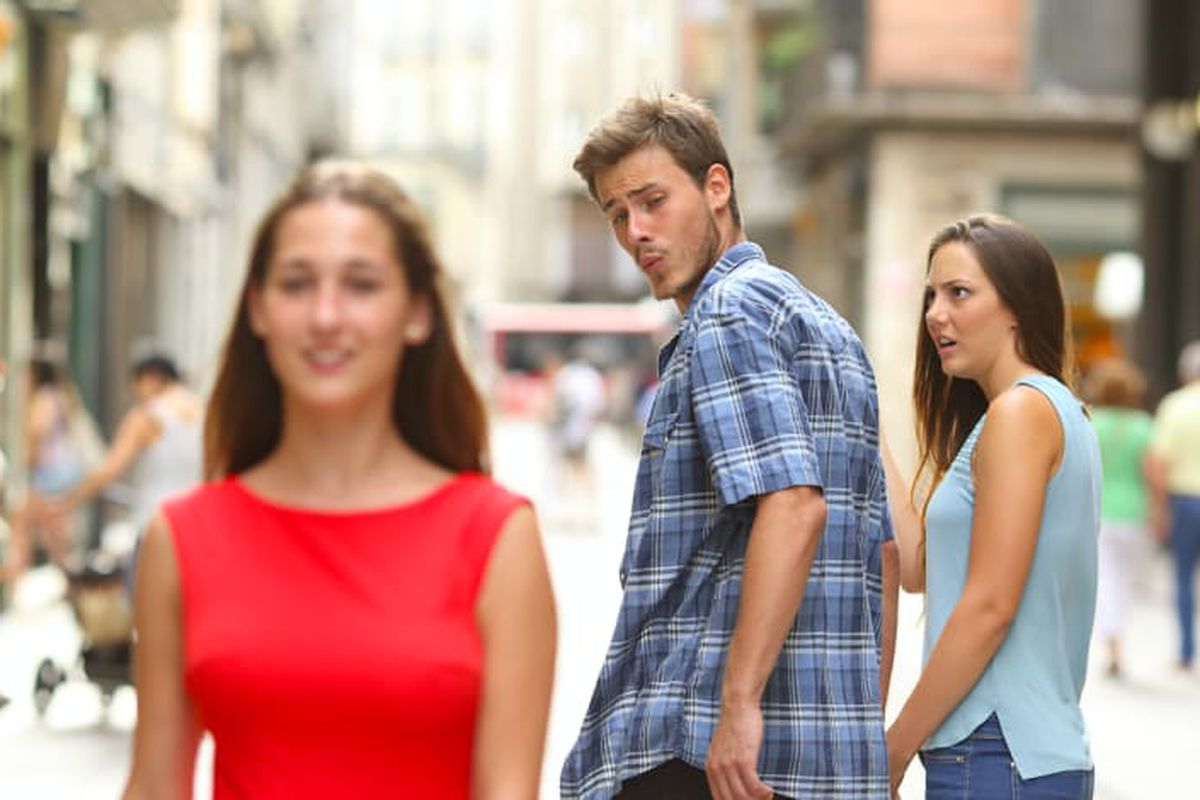

In [ ]:
# Load image #1
url1 = "https://imgflip.com/s/meme/Distracted-Boyfriend.jpg"

response1 = requests.get(url1)

image1 = Image.open(BytesIO(response1.content))
#image1.show()
display(image1)  # This works in Google Colab

In [ ]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.8Gi       255Mi        11Mi        10Gi        10Gi
Swap:             0B          0B          0B


In [ ]:
print(f'Start: {datetime.now()}')
encoded_image1 = model.encode_image(image1)  # Encode image (recommended for multiple operations)
print(f'End: {datetime.now()}')

Start: 2025-02-04 12:16:30.249965
End: 2025-02-04 12:16:31.706568


## Captioning

In [ ]:
print(model.caption(encoded_image1, length="short")["caption"]) # "short" or "normal" (default)

 A young man in a blue plaid shirt and a young woman in a red dress stand in a bustling city street, with a blurred background of people and buildings.


In [ ]:
print(model.caption(encoded_image1, length="normal")["caption"]) # "short" or "normal" (default)

 The image shows a young man in a blue and white plaid shirt and a young woman in a red dress walking down a busy city street. The man is looking back over his shoulder, while the woman is looking ahead. The background is out of focus, but shows other people walking on the street. The man's expression appears to be a mix of surprise and concern, while the woman's expression is neutral.


## Query image

In [ ]:
answer = model.query(encoded_image1, "What woman in a blue blouse is doing?")["answer"]
print("\nAnswer:", answer)  # Single response


Answer:  The woman in a blue blouse is looking at the man in the plaid shirt, who is walking away from her.


## Detect an object

In [ ]:
detect_result = model.detect(encoded_image1, "How many long haired women are in this picture?")
print("\nDetected:", detect_result["objects"])


Detected: [{'x_min': 0.7568359375, 'y_min': 0.2578125, 'x_max': 0.9228515625, 'y_max': 0.62890625}]


Detected only one woman (see picture below)\
**Draw a rectangle on a detected person**

In [ ]:
width, height = image1.size
print(f"width: {width}, height: {height}")

width: 1200, height: 800


In [ ]:
image1_copy = image1.copy()
draw = ImageDraw.Draw(image1_copy)

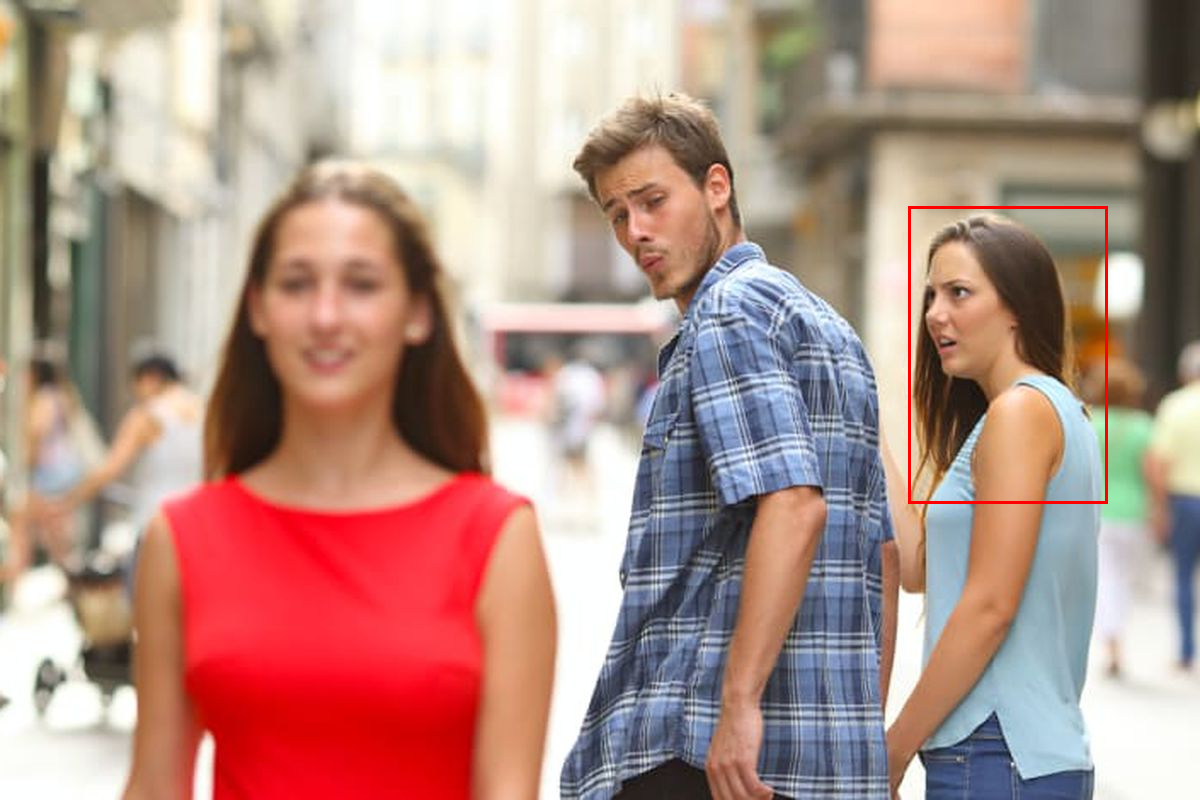

In [ ]:
for obj in detect_result["objects"]:
    x_min = int(obj['x_min'] * width)
    y_min = int(obj['y_min'] * height)
    x_max = int(obj['x_max'] * width)
    y_max = int(obj['y_max'] * height)

    # Draw rectangle (red, thickness 3)
    draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)

# Show the modified image
#image1_copy.show()
display(image1_copy)  # This works in Google Colab

## Point at object

In [ ]:
point_result = model.point(encoded_image1, "How many arms do you see in this picture?")
print("Points:", point_result["points"])

Points: [{'x': 0.1259765625, 'y': 0.849609375}, {'x': 0.423828125, 'y': 0.849609375}, {'x': 0.6328125, 'y': 0.7978515625}, {'x': 0.802734375, 'y': 0.7724609375}, {'x': 0.7451171875, 'y': 0.7197265625}, {'x': 0.9794921875, 'y': 0.5751953125}, {'x': 0.9560546875, 'y': 0.5751953125}, {'x': 0.4990234375, 'y': 0.5166015625}, {'x': 0.4453125, 'y': 0.5166015625}, {'x': 0.1494140625, 'y': 0.5498046875}, {'x': 0.0615234375, 'y': 0.5751953125}]


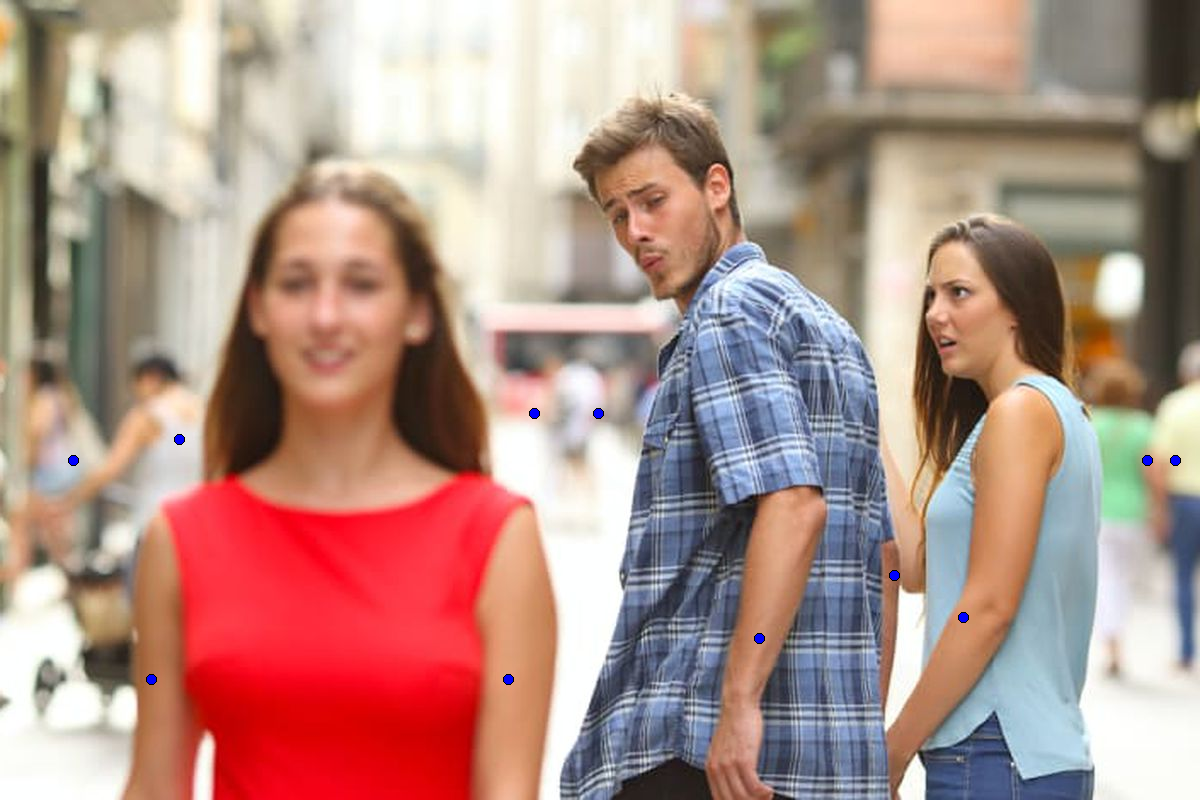

In [ ]:
image2_copy = image1.copy()
draw = ImageDraw.Draw(image2_copy)

# Set point size
radius = 5

# Draw each point
for point in point_result["points"]:
    x = int(point['x'] * width)
    y = int(point['y'] * height)

    # Draw a small circle (dot)
    draw.ellipse([x - radius, y - radius, x + radius, y + radius], fill="blue", outline="black")

# Show the modified image
#image2_copy.show()
display(image2_copy)  # This works in Google Colab

## Gaze detection

In [ ]:
# 1. detect faces
    # from https://github.com/vikhyat/moondream/blob/main/recipes/gaze-detection-video/gaze-detection-video.py#L223
detection_result_faces = model.detect(encoded_image1, "face")
print("\nDetected:", detection_result_faces["objects"])


Detected: [{'x_min': 0.4931640625, 'y_min': 0.19189453125, 'x_max': 0.5869140625, 'y_max': 0.36669921875}, {'x_min': 0.759765625, 'y_min': 0.3037109375, 'x_max': 0.8359375, 'y_max': 0.4716796875}, {'x_min': 0.2138671875, 'y_min': 0.2626953125, 'x_max': 0.3349609375, 'y_max': 0.5126953125}]


In [ ]:
# Sort faces by x_min coordinate for stable colors
    # from: https://github.com/vikhyat/moondream/blob/main/recipes/gaze-detection-video/gaze-detection-video.py#L104
faces = sorted(detection_result_faces["objects"], key=lambda f: (f["y_min"], f["x_min"]))
faces

[{'x_min': 0.4931640625,
  'y_min': 0.19189453125,
  'x_max': 0.5869140625,
  'y_max': 0.36669921875},
 {'x_min': 0.2138671875,
  'y_min': 0.2626953125,
  'x_max': 0.3349609375,
  'y_max': 0.5126953125},
 {'x_min': 0.759765625,
  'y_min': 0.3037109375,
  'x_max': 0.8359375,
  'y_max': 0.4716796875}]

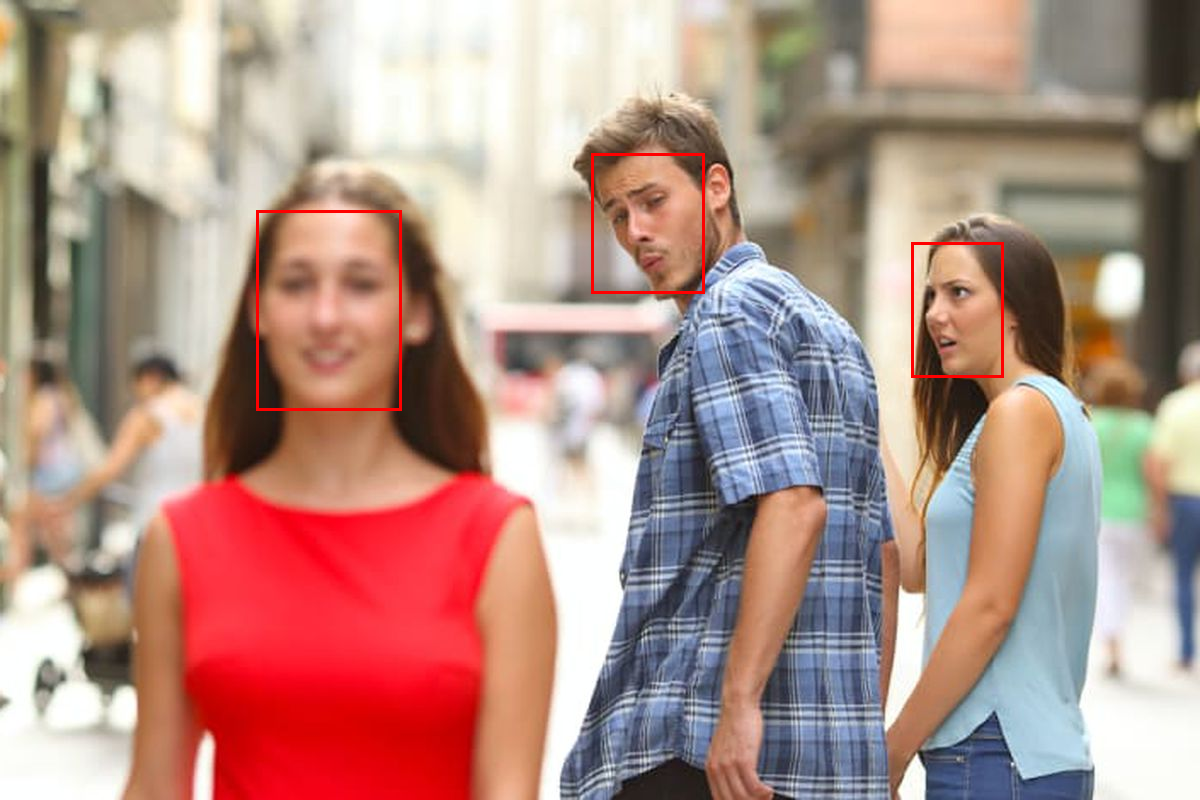

In [ ]:
image2_copy = image1.copy()
draw = ImageDraw.Draw(image2_copy)

for obj in faces:
    x_min = int(obj['x_min'] * width)
    y_min = int(obj['y_min'] * height)
    x_max = int(obj['x_max'] * width)
    y_max = int(obj['y_max'] * height)

    # Draw rectangle (red, thickness 3)
    draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)

# Show the modified image
#image2_copy.show()
display(image2_copy)  # This works in Google Colab

In [ ]:
# Generate colors (for rectangle)
colors = plt.cm.rainbow(np.linspace(0, 1, max(1, len(faces))))
colors

array([[5.00000000e-01, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [5.03921569e-01, 9.99981027e-01, 7.04925547e-01, 1.00000000e+00],
       [1.00000000e+00, 1.22464680e-16, 6.12323400e-17, 1.00000000e+00]])

Gaze: {'x': 0.2939453125, 'y': 0.3662109375}
Gaze: None
Gaze: {'x': 0.279296875, 'y': 0.3662109375}


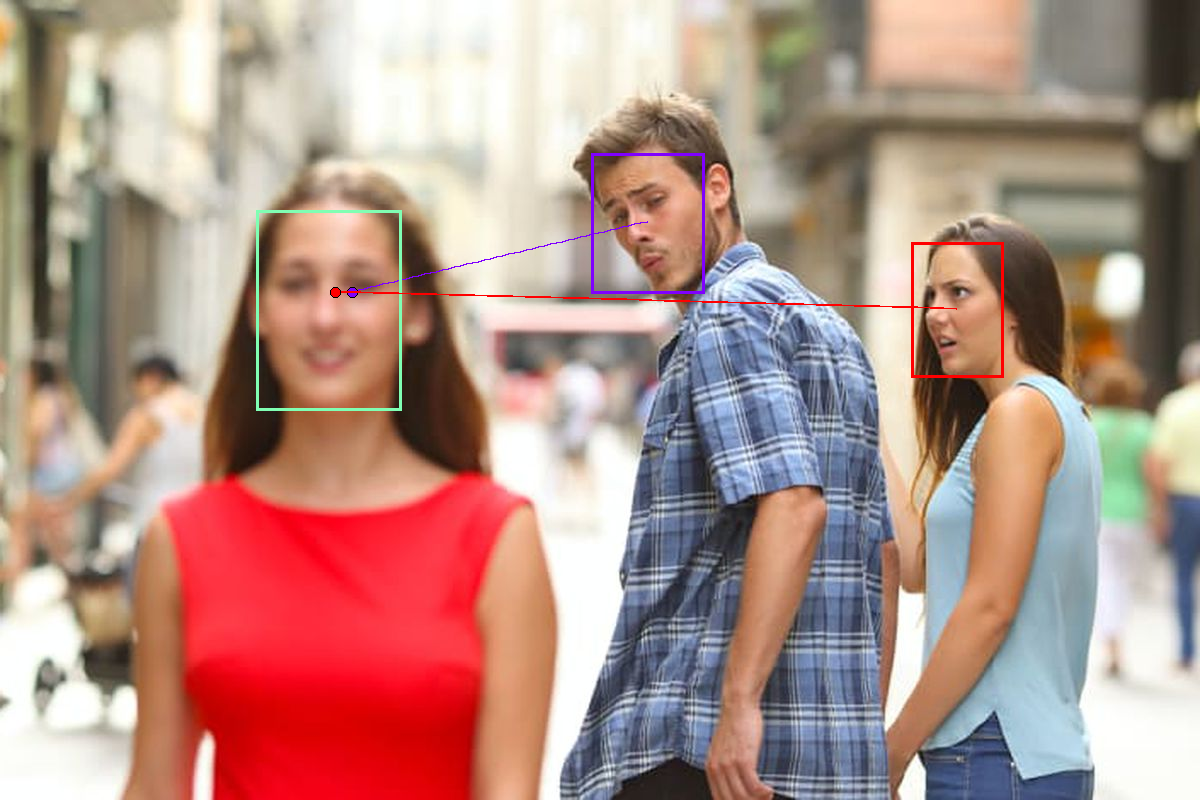

In [ ]:
image3_copy = image1.copy()
draw = ImageDraw.Draw(image3_copy)

# Process each face
for face, color in zip(faces, colors):
    try:
        # Calculate face box coordinates
        x_min = int(float(face["x_min"]) * width)
        y_min = int(float(face["y_min"]) * height)
        x_max = int(float(face["x_max"]) * width)
        y_max = int(float(face["y_max"]) * height)
        face_border_width = int(float(face["x_max"] - face["x_min"]) * width)
        face_border_height = int(float(face["y_max"] - face["y_min"]) * height)

        # Draw face bounding box
        face_color = tuple(int(c * 255) for c in color[:3])  # Convert color from (0-1) to (0-255)
        draw.rectangle([x_min, y_min, x_max, y_max], outline=face_color, width=3)

        # Calculate face center
        face_center = (
            float(face["x_min"] + face["x_max"]) / 2,
            float(face["y_min"] + face["y_max"]) / 2,
            )

        # Try to detect gaze
        try:
            gaze_result = model.detect_gaze(encoded_image1, face_center)
            if isinstance(gaze_result, dict) and "gaze" in gaze_result:
                gaze = gaze_result["gaze"]
                print(f'Gaze: {gaze}')
            else:
                gaze = gaze_result
        except Exception as e:
            print(f"Error detecting gaze: {e}")
            continue

        if (
            gaze is not None
            and isinstance(gaze, dict)
            and "x" in gaze
            and "y" in gaze
            ):
            gaze_x = int(float(gaze["x"]) * width)
            gaze_y = int(float(gaze["y"]) * height)
            face_center_x = x_min + face_border_width // 2
            face_center_y = y_min + face_border_height // 2

            # Draw gaze line with gradient effect
            points = 50
            alphas = np.linspace(0.8, 0, points)

            # Calculate points along the line
            x_points = np.linspace(face_center_x, gaze_x, points)
            y_points = np.linspace(face_center_y, gaze_y, points)

            # Draw gradient line segments
            for i in range(points - 1):
                alpha = int(255 * alphas[i])  # Convert to 0-255
                segment_color = (face_color[0], face_color[1], face_color[2], alpha)  # RGBA

                # Draw segment line
                draw.line([(x_points[i], y_points[i]), (x_points[i + 1], y_points[i + 1])], fill=segment_color, width=2)

            # Draw gaze point
            radius = 5  # Size of gaze point
            draw.ellipse([gaze_x - radius, gaze_y - radius, gaze_x + radius, gaze_y + radius], fill=face_color, outline="black")

    except Exception as e:
        print(f"Error processing face: {e}")
        continue

# Show the modified image
#image2_copy.show()
display(image3_copy)  # This works in Google Colab

## JSON format

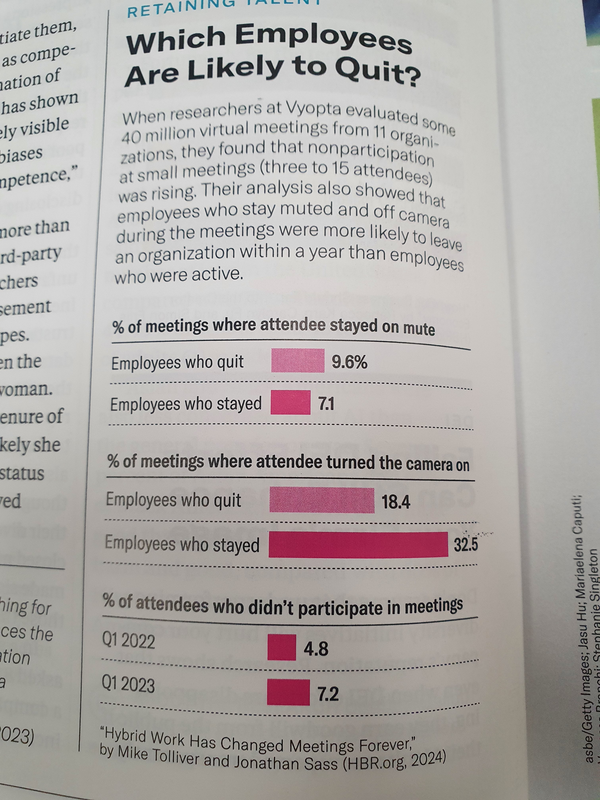

In [35]:
# Load image #2
url2 = 'https://raw.githubusercontent.com/aivisbr/diff_files/140bf2a6c89ee4f2fc1af43c94c42cd81557440f/20241011_102538.jpg'

response2 = requests.get(url2)

image2 = Image.open(BytesIO(response2.content))

# Resize while maintaining aspect ratio
base_width = 800  # Change this to your desired width
w_percent = base_width / float(image2.width)
h_size = int((float(image2.height) * float(w_percent)))
image2 = image2.resize((base_width, h_size), Image.Resampling.LANCZOS)

# Rotate the image 90 degrees counter-clockwise
image2 = image2.rotate(-90, expand=True) # expand=True to avoid cropping

#image2.show()
display(image2)  # This works in Google Colab

In [36]:
print(f'Start: {datetime.now()}')
encoded_image2 = model.encode_image(image2)  # Encode image (recommended for multiple operations)
print(f'End: {datetime.now()}')

Start: 2025-02-04 12:56:57.760196
End: 2025-02-04 12:56:58.371385


In [38]:
answer2 = model.query(encoded_image2, "Extract survey questions, give categories of these questions and amount - how many respondents answered to this question. Return result in a JSON format. In the result include also data source.")["answer"]
print(answer2)

 [
  {
    "category": "Employees who quit",
    "question": "What percentage of employees who quit?",
    "answer": 9.6,
    "source": "Yoopta"
  },
  {
    "category": "Employees who stayed",
    "question": "What percentage of employees who stayed?",
    "answer": 71,
    "source": "Yoopta"
  },
  {
    "category": "Employees who turned the camera on",
    "question": "What percentage of employees who turned the camera on?",
    "answer": 18.4,
    "source": "Yoopta"
  },
  {
    "category": "Employees who didn't participate in meetings",
    "question": "What percentage of employees who didn't participate in meetings?",
    "answer": 4.8,
    "source": "Yoopta"
  },
  {
    "category": "Hybrid Work Has Changed Meetings Forever",
    "question": "What percentage of employees who had hybrid work arrangements?",
    "answer": 7.2,
    "source": "Yoopta"
  }
]


## OCR

In [39]:
answer3 = model.query(encoded_image2, "There is a summary before the survey result. Extract this summary.")["answer"]
print(answer3)

 When researchers at Yoopyta evaluated some 40 million virtual meetings from 11 organizations, they found that nonparticipation at small meetings (three to 15 attendees) was rising. Their analysis also showed that employees who stay used more likely to leave an organization within a year than employees who were active.
